In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import zscore
import os
import xarray as xr
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import sosfilt

%matplotlib inline

In [4]:
# loading bruce LFP, .npy

lfp = np.load('/cs/projects/OWVinckSWR/DL/predSWR/bruce_dataset/LFP_sanity_check/LFP_Bruce_Probe1.npy')


In [5]:
def bandpass_filter(signal, low_f, high_f, sampling_rate=1250, filter_order=5):

    filter = butter(filter_order, [low_f, high_f],
                    btype='bandpass', output='sos', fs=sampling_rate)
    filtered_signal = sosfiltfilt(filter, signal)
    return filtered_signal

In [7]:
print("Loading data...", end=" ")
# Sampling rate 
fs = 1250 
# To load data 
docs_dir=os.path.expanduser('/cs/projects/OWVinckSWR/DL/predSWR/bruce_dataset/probabilities_online')
base_online_prob = np.load(os.path.join(docs_dir, 'online_prob_bruce_Base_K4_T50_D3_N32_L4_E200_B32_S50_AnchorNarrowSmooth_GloWReg_Shift00_0.npy'), allow_pickle=True)
# we need to get rid of the first 50 because they are 0 
base_online_prob = base_online_prob[50:]
online_prob_CNN1D = np.load(os.path.join(docs_dir, 'online_prob_rippAI_bruce_CNN1D_0.npy'), allow_pickle=True)
online_prob_CNN2D = np.load(os.path.join(docs_dir, 'online_prob_rippAI_bruce_CNN2D_0.npy'), allow_pickle=True)
online_prob_LSTM = np.load(os.path.join(docs_dir, 'online_prob_rippAI_bruce_LSTM_0.npy'), allow_pickle=True)
print("Done.")  

Loading data... Done.


In [8]:
# Method 1: envelope 
ripple_pred_times_M1 = np.load('/cs/projects/OWVinckSWR/DL/predSWR/bruce_dataset/LFP_sanity_check/M1_M2_methods/ripple_pred_times_M1_bruce_probe1.npy')

# Method 2: wavelet
ripple_pred_times_M2 = np.load('/cs/projects/OWVinckSWR/DL/predSWR/bruce_dataset/LFP_sanity_check/M1_M2_methods/ripple_pred_times_M2_bruce_probe1.npy')




In [7]:
# Loading CNN2D no online
docs_dir=os.path.expanduser('/cs/projects/OWVinckSWR/Carmen/LFP_extracted/time_comparison')
offline_prob_CNN2D = np.load(os.path.join(docs_dir, 'ripple_pred_times_CNN2D_80.npy'), allow_pickle=True)

# /cs/projects/OWVinckSWR/Carmen/LFP_extracted/ripple_pred_times_CNN2D_80.npy
docs_dir = os.path.expanduser('/cs/projects/OWVinckSWR/Carmen/LFP_extracted')
offline_prob_CNN2D_2 = np.load(os.path.join(docs_dir, 'ripple_pred_times_CNN2D_80.npy'), allow_pickle=True)

# /cs/projects/OWVinckSWR/DL/predSWR/allen_dataset/probabilities/prob_rippAI_CNN1D_0.npy
docs_dir = os.path.expanduser('/cs/projects/OWVinckSWR/DL/predSWR/allen_dataset/probabilities')
offline_prob_CNN1D = np.load(os.path.join(docs_dir, 'prob_rippAI_CNN1D_0.npy'), allow_pickle=True)

# comparing shapes of the offline arrays
print("CNN2D: ", offline_prob_CNN2D.shape)
print("CNN2D_2: ", offline_prob_CNN2D_2.shape)
print("CNN1D: ", offline_prob_CNN1D.shape)


CNN2D:  (2534, 2)
CNN2D_2:  (2534, 2)
CNN1D:  (12132937,)


In [9]:
# Printing the shape of the data

print("LFP shape: ", lfp.shape)
print("base_online_prob shape: ", base_online_prob.shape)
print("online_prob_CNN1D shape: ", online_prob_CNN1D.shape)
print("online_prob_CNN2D shape: ", online_prob_CNN2D.shape)
print("online_prob_LSTM shape: ", online_prob_LSTM.shape)
print("ripple_pred_times_M1 shape: ", ripple_pred_times_M1.shape)
print("ripple_pred_times_M2 shape: ", ripple_pred_times_M2.shape)


LFP shape:  (27001080, 86)
base_online_prob shape:  (27001080,)
online_prob_CNN1D shape:  (27001080,)
online_prob_CNN2D shape:  (27001080,)
online_prob_LSTM shape:  (27001080,)
ripple_pred_times_M1 shape:  (27001080,)
ripple_pred_times_M2 shape:  (27001080,)


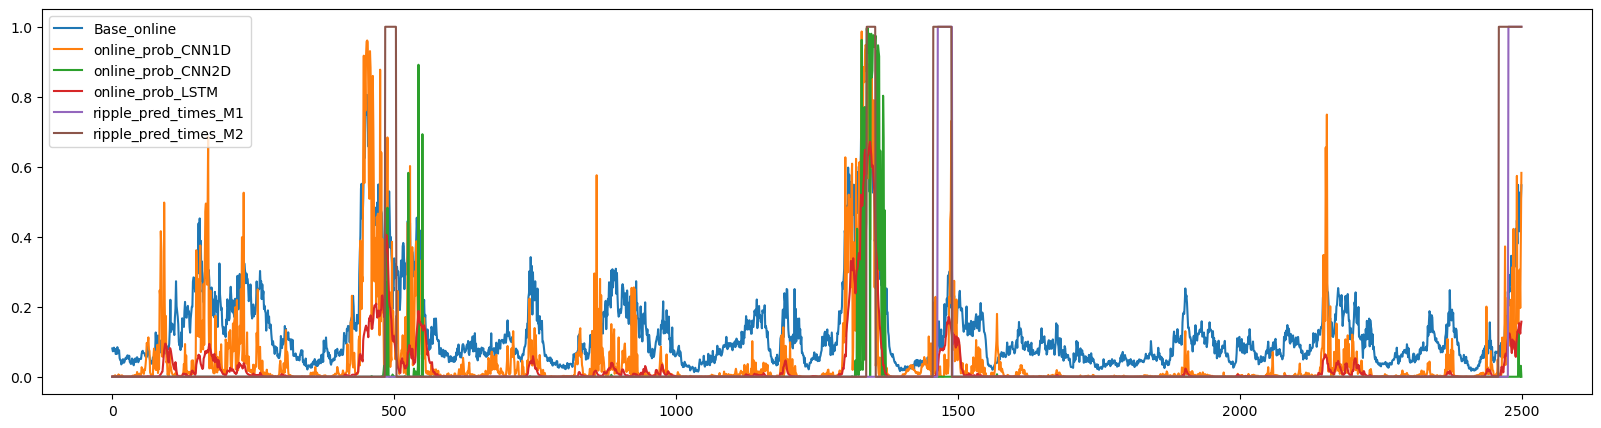

In [10]:
#Plotting a snippet of the data, adding M1 and M2 methods
start = 2794491 - 50
end = 2795154 + 50
start = 1239413 - 200
end = start + 1250*2
plt.figure(figsize=(20, 5))
plt.plot(base_online_prob[start:end], label='Base_online')
plt.plot(online_prob_CNN1D[start:end], label='online_prob_CNN1D')
plt.plot(online_prob_CNN2D[start:end], label='online_prob_CNN2D')
plt.plot(online_prob_LSTM[start:end], label='online_prob_LSTM')
plt.plot(ripple_pred_times_M1[start:end], label='ripple_pred_times_M1')
plt.plot(ripple_pred_times_M2[start:end], label='ripple_pred_times_M2')
plt.legend()
plt.show()

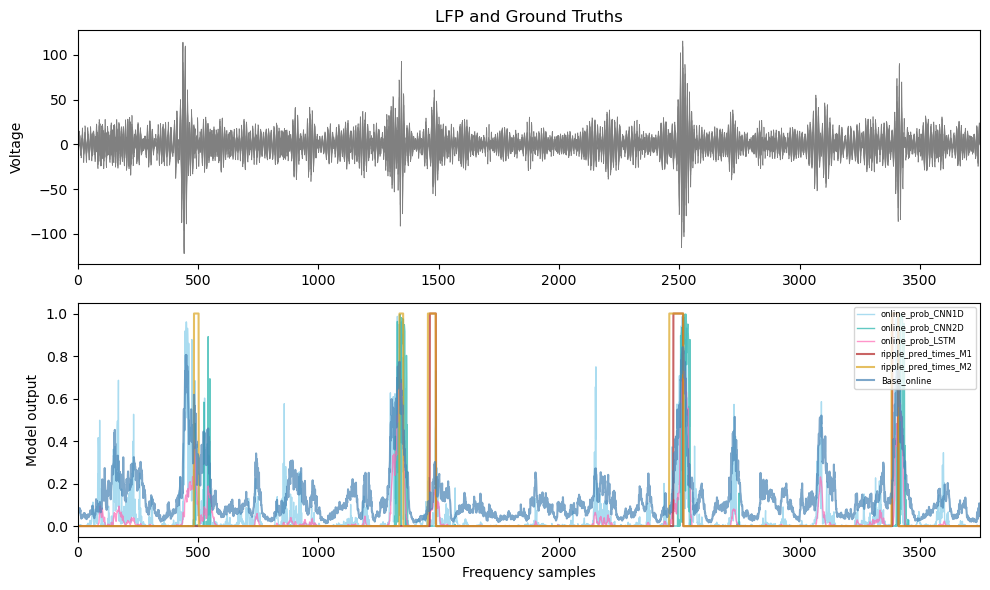

In [13]:
# Define indices for LFP channels (grayscale)
# indeces = np.int32(np.linspace(33, 40, 8)) # allen
indeces = np.int32(np.linspace(24,31,8)) # probe 1: 
# indeces = np.int32(np.linspace(31,38,8)) # probe 2:
#indeces[::-1].sort()

# Sampling frequency and time window
fs = 1250

# Create two vertically aligned subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1]})
start = 1239413 - 200
end = start + 1250 * 3


# Offset for plotting LFP channels
j = 0.002  
for idx, i in enumerate(indeces):
    lfp_aux = lfp[np.int32(start):np.int32(end), i] - np.mean(lfp[:, i], axis=0)
    
    # Apply bandpass filter in the frequency range 100-150 Hz
    lfp_filtered = bandpass_filter(lfp_aux, 100, 150, fs)
    
    # Plot LFP channels with grayscale color
    ax1.plot(lfp_filtered + j, color='gray', linewidth=0.5)
    j += 0.0003

# Set labels and title for the first plot (LFP)
ax1.set_ylabel('Voltage')
ax1.set_title('LFP and Ground Truths')

# Plot the probability models on the second axis
probability_colors = ["deepskyblue", "magenta", "palegreen", "hotpink", "firebrick", "goldenrod"]
probability_colors = ["cornflowerblue", "orchid", "lightgreen", "lightcoral", "salmon", "khaki"]
probability_colors = [ "steelblue","skyblue", "lightseagreen", "hotpink", "firebrick", "goldenrod"]
# Plot probability models

ax2.plot(online_prob_CNN1D[start:end], label='online_prob_CNN1D', color=probability_colors[1], linewidth=1, alpha=0.7)
ax2.plot(online_prob_CNN2D[start:end], label='online_prob_CNN2D', color=probability_colors[2], linewidth=1, alpha=0.7)
ax2.plot(online_prob_LSTM[start:end], label='online_prob_LSTM', color=probability_colors[3], linewidth=1, alpha=0.7)
ax2.plot(ripple_pred_times_M1[start:end], label='ripple_pred_times_M1', color=probability_colors[4], linewidth=1.5, alpha=0.7)
ax2.plot(ripple_pred_times_M2[start:end], label='ripple_pred_times_M2', color=probability_colors[5], linewidth=1.5, alpha=0.7)
ax2.plot(base_online_prob[start:end], label='Base_online', color=probability_colors[0], linewidth=1.5, alpha=0.7)

# Set labels for the second plot
ax2.set_xlabel('Frequency samples')
ax2.set_ylabel('Model output')

# Create legend for the second plot
ax2.legend(loc='upper right', prop={'size': 6})

# Formatting for both subplots
ax1.set_xlim(0, end - start)
ax2.set_xlim(0, end - start)

# Display the plot
plt.tight_layout()
plt.show()

In [14]:
# Define indices for LFP channels (grayscale)
#indeces = np.int32(np.linspace(33, 40, 8))
#indeces[::-1].sort()

# Sampling frequency and time window
fs = 1250
start = 0
while start < lfp.shape[0]:
    # Create two vertically aligned subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1]})
    end = start + 1250 * 3


    # Offset for plotting LFP channels
    j = 0.002  
    for idx, i in enumerate(indeces):
        lfp_aux = lfp[np.int32(start):np.int32(end), i] - np.mean(lfp[:, i], axis=0)
        
        # Apply bandpass filter in the frequency range 100-150 Hz
        lfp_filtered = bandpass_filter(lfp_aux, 100, 150, fs)
        
        # Plot LFP channels with grayscale color
        ax1.plot(lfp_filtered + j, color='gray', linewidth=0.5)
        j += 0.0003

    # Set labels and title for the first plot (LFP)
    ax1.set_ylabel('Voltage')
    ax1.set_title('LFP and Ground Truths')

    # Plot the probability models on the second axis
    probability_colors = [ "steelblue","lightseagreen", "skyblue", "hotpink", "firebrick", "goldenrod"]
    # Plot probability models

    ax2.plot(online_prob_CNN1D[start:end], label='online_prob_CNN1D', color=probability_colors[1], linewidth=1, alpha=0.7)
    ax2.plot(online_prob_CNN2D[start:end], label='online_prob_CNN2D', color=probability_colors[2], linewidth=1, alpha=0.7)
    ax2.plot(online_prob_LSTM[start:end], label='online_prob_LSTM', color=probability_colors[3], linewidth=1, alpha=0.7)
    ax2.plot(ripple_pred_times_M1[start:end], label='ripple_pred_times_M1', color=probability_colors[4], linewidth=1.5, alpha=0.7)
    ax2.plot(ripple_pred_times_M2[start:end], label='ripple_pred_times_M2', color=probability_colors[5], linewidth=1.5, alpha=0.7)
    ax2.plot(base_online_prob[start:end], label='Base_online', color=probability_colors[0], linewidth=1.5, alpha=0.7)

    # Set labels for the second plot
    ax2.set_xlabel('Frequency samples')
    ax2.set_ylabel('Model output')

    # Create legend for the second plot
    ax2.legend(loc='upper right', prop={'size': 6})

    # Formatting for both subplots
    ax1.set_xlim(0, end - start)
    ax2.set_xlim(0, end - start)

    

    # Saving the image 
    plt.tight_layout()
    directory =  '/cs/projects/OWVinckSWR/DL/predSWR/bruce_dataset/online_images/all_models/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + '{0}.png'.format(start))
    start = end
    

/tmp/ipykernel_3226429/2119810960.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1]})
